# **1 Imports**

In [1]:
# Mount drive
from google.colab import drive; drive.mount('/content/drive')

# CD to current directory
%cd /content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Notebooks/Model Comparison

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Notebooks/Model Comparison


In [2]:
cbscolor = (73/255, 103/255, 170/255)

In [3]:
! sudo apt-get update
! sudo apt-get install texlive-latex-recommended
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip
! unzip type1cm.zip -d /tmp/type1cm
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm
! sudo texhash
!apt install cm-super
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "text.latex.preamble": r"""
        \usepackage{type1cm}
        \usepackage{amsmath}
    """
})

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease [24.6 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,683 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,245 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [4,387 kB]
Get:1

## **1.1 Packages**

In [4]:
!pip install -q model-confidence-set

import gc
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from model_confidence_set import ModelConfidenceSet

## **1.2 Data**

We note that the models need different datastructures. FFNN and D-FFNN use $D \in \mathbb{R}^{(F \cdot T) \times F}$ and RNN and LSTM use $D \in \mathbb{R}^{N \times T \times F}$

### **1.2.1 Import**

In [5]:
# Relative location of data
DATA_RLOC = '../Data/handoffs/data_stock_returns_final.parquet'

# Load data and sort by eom
securities_data = pd.read_parquet(DATA_RLOC)
securities_data = securities_data.sort_values(by=['id', 'eom'])

# List of features and the label
features = [
    feat for feat in securities_data.columns
    if feat not in ['eom', 'id', 'ret_exc_lead1m']
]

label = 'ret_exc_lead1m'

### **1.2.2 Processing Functions**

In [6]:
def build_tensors(securities_data, features, label, window_len):
  """
  Takes dataframe as input, the features, and labels and returns a feature
  tensor of dimension (N, T, F) and a label tensor of dimension (N, T, 1)
  """

  # Ensure data is sorted correctly
  securities_data = securities_data.sort_values(by=['id', 'eom'])

  X_all, y_all = [], []

  for _, group in securities_data.groupby('id', sort=False):
      feats  = group[features].values
      labels = group[label].values.reshape(-1, 1)
      D = len(group)

      for start in range(D - window_len + 1):
          end = start + window_len
          X_all.append(feats[start:end])    # (T, F)
          y_all.append(labels[start:end])   # (T, 1)

  X = np.stack(X_all)  # (N, T, F)
  y = np.stack(y_all)  # (N, T, 1)

  del X_all, y_all, group, label, features
  gc.collect()
  return X, y

### **1.2.3 Train/Validation/Test Split**

In [7]:
# Time-based split
months = sorted(securities_data['eom'].unique())
n      = len(months)
splits = [int(n * 0.7), int(n * 0.85)]

month_bins = [
    months[:splits[0]],             # Train
    months[splits[0]:splits[1]],    # Validation
    months[splits[1]:],             # Test
]


# securities_data[0]: train data
# securities_data[1]: validation data
# securities_data[2]: test data
securities_data = [
    securities_data[securities_data['eom'].isin(m)] for m in month_bins
]

We create train/validation/test splits for each model.

In [8]:
# Train, validation and test data for FFNN and D-FFNN
ff_X_train, ff_y_train = securities_data[0][features], securities_data[0][label]
ff_X_val,   ff_y_val   = securities_data[1][features], securities_data[1][label]
ff_X_test,  ff_y_test  = securities_data[2][features], securities_data[2][label]

# Train, validation and test data for RNN
rnn_X_train, rnn_y_train = build_tensors(securities_data[0], features, label, 36)
rnn_X_val,   rnn_y_val   = build_tensors(securities_data[1], features, label, 36)
rnn_X_test,  rnn_y_test  = build_tensors(securities_data[2], features, label, 36)

# Train, validation and test data for LSTM
lstm_X_train, lstm_y_train = build_tensors(securities_data[0], features, label, 6)
lstm_X_val,   lstm_y_val   = build_tensors(securities_data[1], features, label, 6)
lstm_X_test,  lstm_y_test  = build_tensors(securities_data[2], features, label, 6)

In [9]:
del securities_data

## **1.3 models**

In [10]:
# Relative location of Keras models
FFNN_RLOC  = '../Feed Forward Neural Nets/models studies/final_model_fnn.keras'
DFFNN_RLOC = '../Deep Neural Networks/models studies/final_model_dffn.keras'
RNN_RLOC   = '../Recurrent Neural Nets/models studies/final_model_rnn.keras'
LSTM_RLOC  = '../LSTM/models studies/final_model_lstm.keras'

# Load models
ffnn  = tf.keras.models.load_model(FFNN_RLOC)
dffnn = tf.keras.models.load_model(DFFNN_RLOC)
rnn   = tf.keras.models.load_model(RNN_RLOC)
lstm  = tf.keras.models.load_model(LSTM_RLOC)

# **2 Visualization of Predicted Returns**

We compare the distribution of the predicted returns aginst the actual recorded returns. This is done only for the test data.

## **2.1 Predictions on test data**

First we make the predictions.

In [11]:
ffnn_pred = ffnn.predict(ff_X_test, verbose=0).flatten()
dffnn_pred = dffnn.predict(ff_X_test, verbose=0).flatten()
rnn_pred = rnn.predict(rnn_X_test, verbose=0).flatten()
lstm_pred = lstm.predict(lstm_X_test, verbose=0).flatten()

In [12]:
ffnn_true = ff_y_test.values
dffnn_true = ff_y_test.values
rnn_true = rnn_y_test.flatten()
lstm_true = lstm_y_test.flatten()

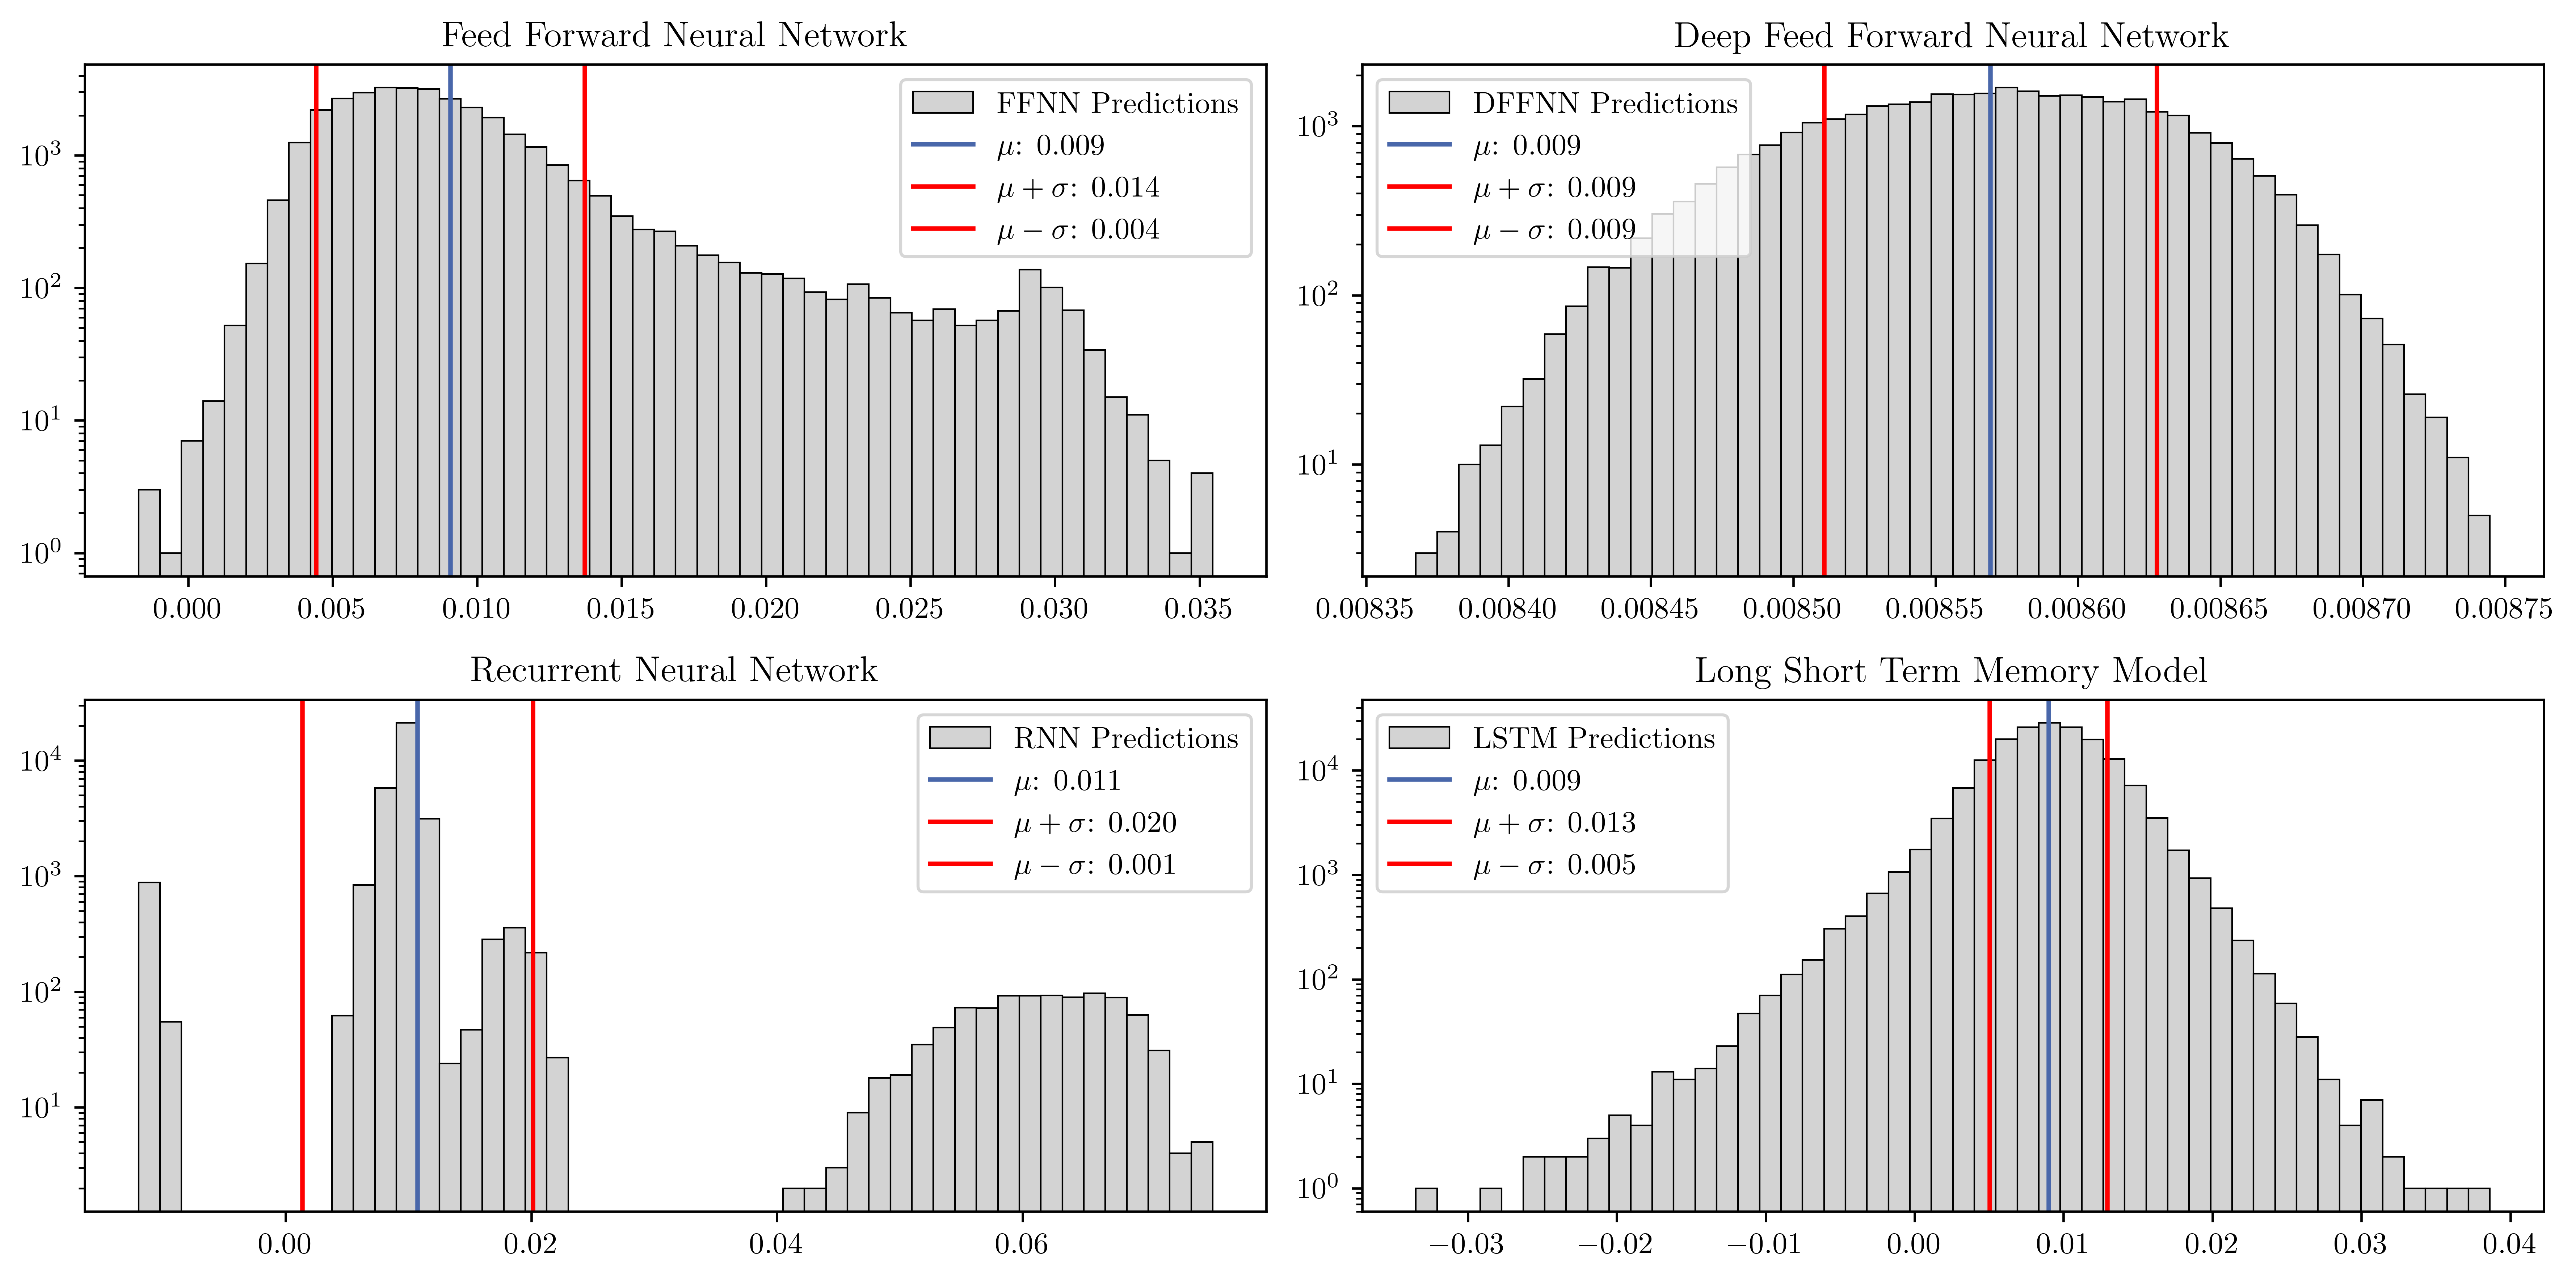

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2x2 grid for the subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 6), dpi=600)

# Define a helper function to add mean, median, and standard deviation lines
def add_stat_lines(ax, data, label):
    mean = np.mean(data)
    median = np.median(data)
    std = np.std(data)

    # Add lines for mean, median, and std
    ax.axvline(mean,       color=cbscolor,  linewidth=1.5,   label=r'$\mu$: {:.3f}'.format(mean))
    ax.axvline(mean + std, color='red',     linewidth=1.5,   label=r'$\mu + \sigma$: {:.3f}'.format(mean + std))
    ax.axvline(mean - std, color='red',     linewidth=1.5,   label=r'$\mu - \sigma$: {:.3f}'.format(mean - std))


    # Labeling the plot
    ax.set_title(label)
    ax.set_yscale('log')  # Set the y-axis to log scale

    ax.legend()

# FFNN Histogram
axs[0, 0].hist(ffnn_pred, bins=50, label="FFNN Predictions", color="lightgray", edgecolor="black", linewidth=0.5)
add_stat_lines(axs[0, 0], ffnn_pred, 'Feed Forward Neural Network')

# DFFNN Histogram
axs[0, 1].hist(dffnn_pred, bins=50, label="DFFNN Predictions", color="lightgray", edgecolor="black", linewidth=0.5)
add_stat_lines(axs[0, 1], dffnn_pred, 'Deep Feed Forward Neural Network')

# RNN Histogram
axs[1, 0].hist(rnn_pred, bins=50, label="RNN Predictions", color="lightgray", edgecolor="black", linewidth=0.5)
add_stat_lines(axs[1, 0], rnn_pred, 'Recurrent Neural Network')

# LSTM Histogram
axs[1, 1].hist(lstm_pred, bins=50, label="LSTM Predictions", color="lightgray", edgecolor="black", linewidth=0.5)
add_stat_lines(axs[1, 1], lstm_pred, 'Long Short Term Memory Model')

# Adjust layout for better spacing
plt.tight_layout()

# Save and show plot
plt.savefig("pred_distributions.pdf", bbox_inches='tight')
plt.show()

Below we summarize some key distributional differences of the plot above.

In [14]:
print(f"{'Test sample true mean:':40s} {ff_y_test.mean()}")
print(f"{'FFNN sample mean:':40s} {ffnn_pred.mean()}")
print(f"{'DFFNN sample mean:':40s} {dffnn_pred.mean()}")
print(f"{'RNN sample mean:':40s} {rnn_pred.mean()}")
print(f"{'LSTM sample mean:':40s} {lstm_pred.mean()}")
print(f"{'Test sample true variance:':40s} {ff_y_test.var()}")
print(f"{'FFNN sample variance:':40s} {ffnn_pred.var()}")
print(f"{'DFFNN sample variance:':40s} {dffnn_pred.var()}")
print(f"{'RNN sample variance:':40s} {rnn_pred.var()}")
print(f"{'LSTM sample variance:':40s} {lstm_pred.var()}")

Test sample true mean:                   0.006080972567972118
FFNN sample mean:                        0.009069492109119892
DFFNN sample mean:                       0.008569241501390934
RNN sample mean:                         0.01073866244405508
LSTM sample mean:                        0.008985854685306549
Test sample true variance:               0.010745897411350548
FFNN sample variance:                    2.1629637558362447e-05
DFFNN sample variance:                   3.411487980997663e-09
RNN sample variance:                     8.826825069263577e-05
LSTM sample variance:                    1.5617704775650054e-05


## **2.2 Non log scale**

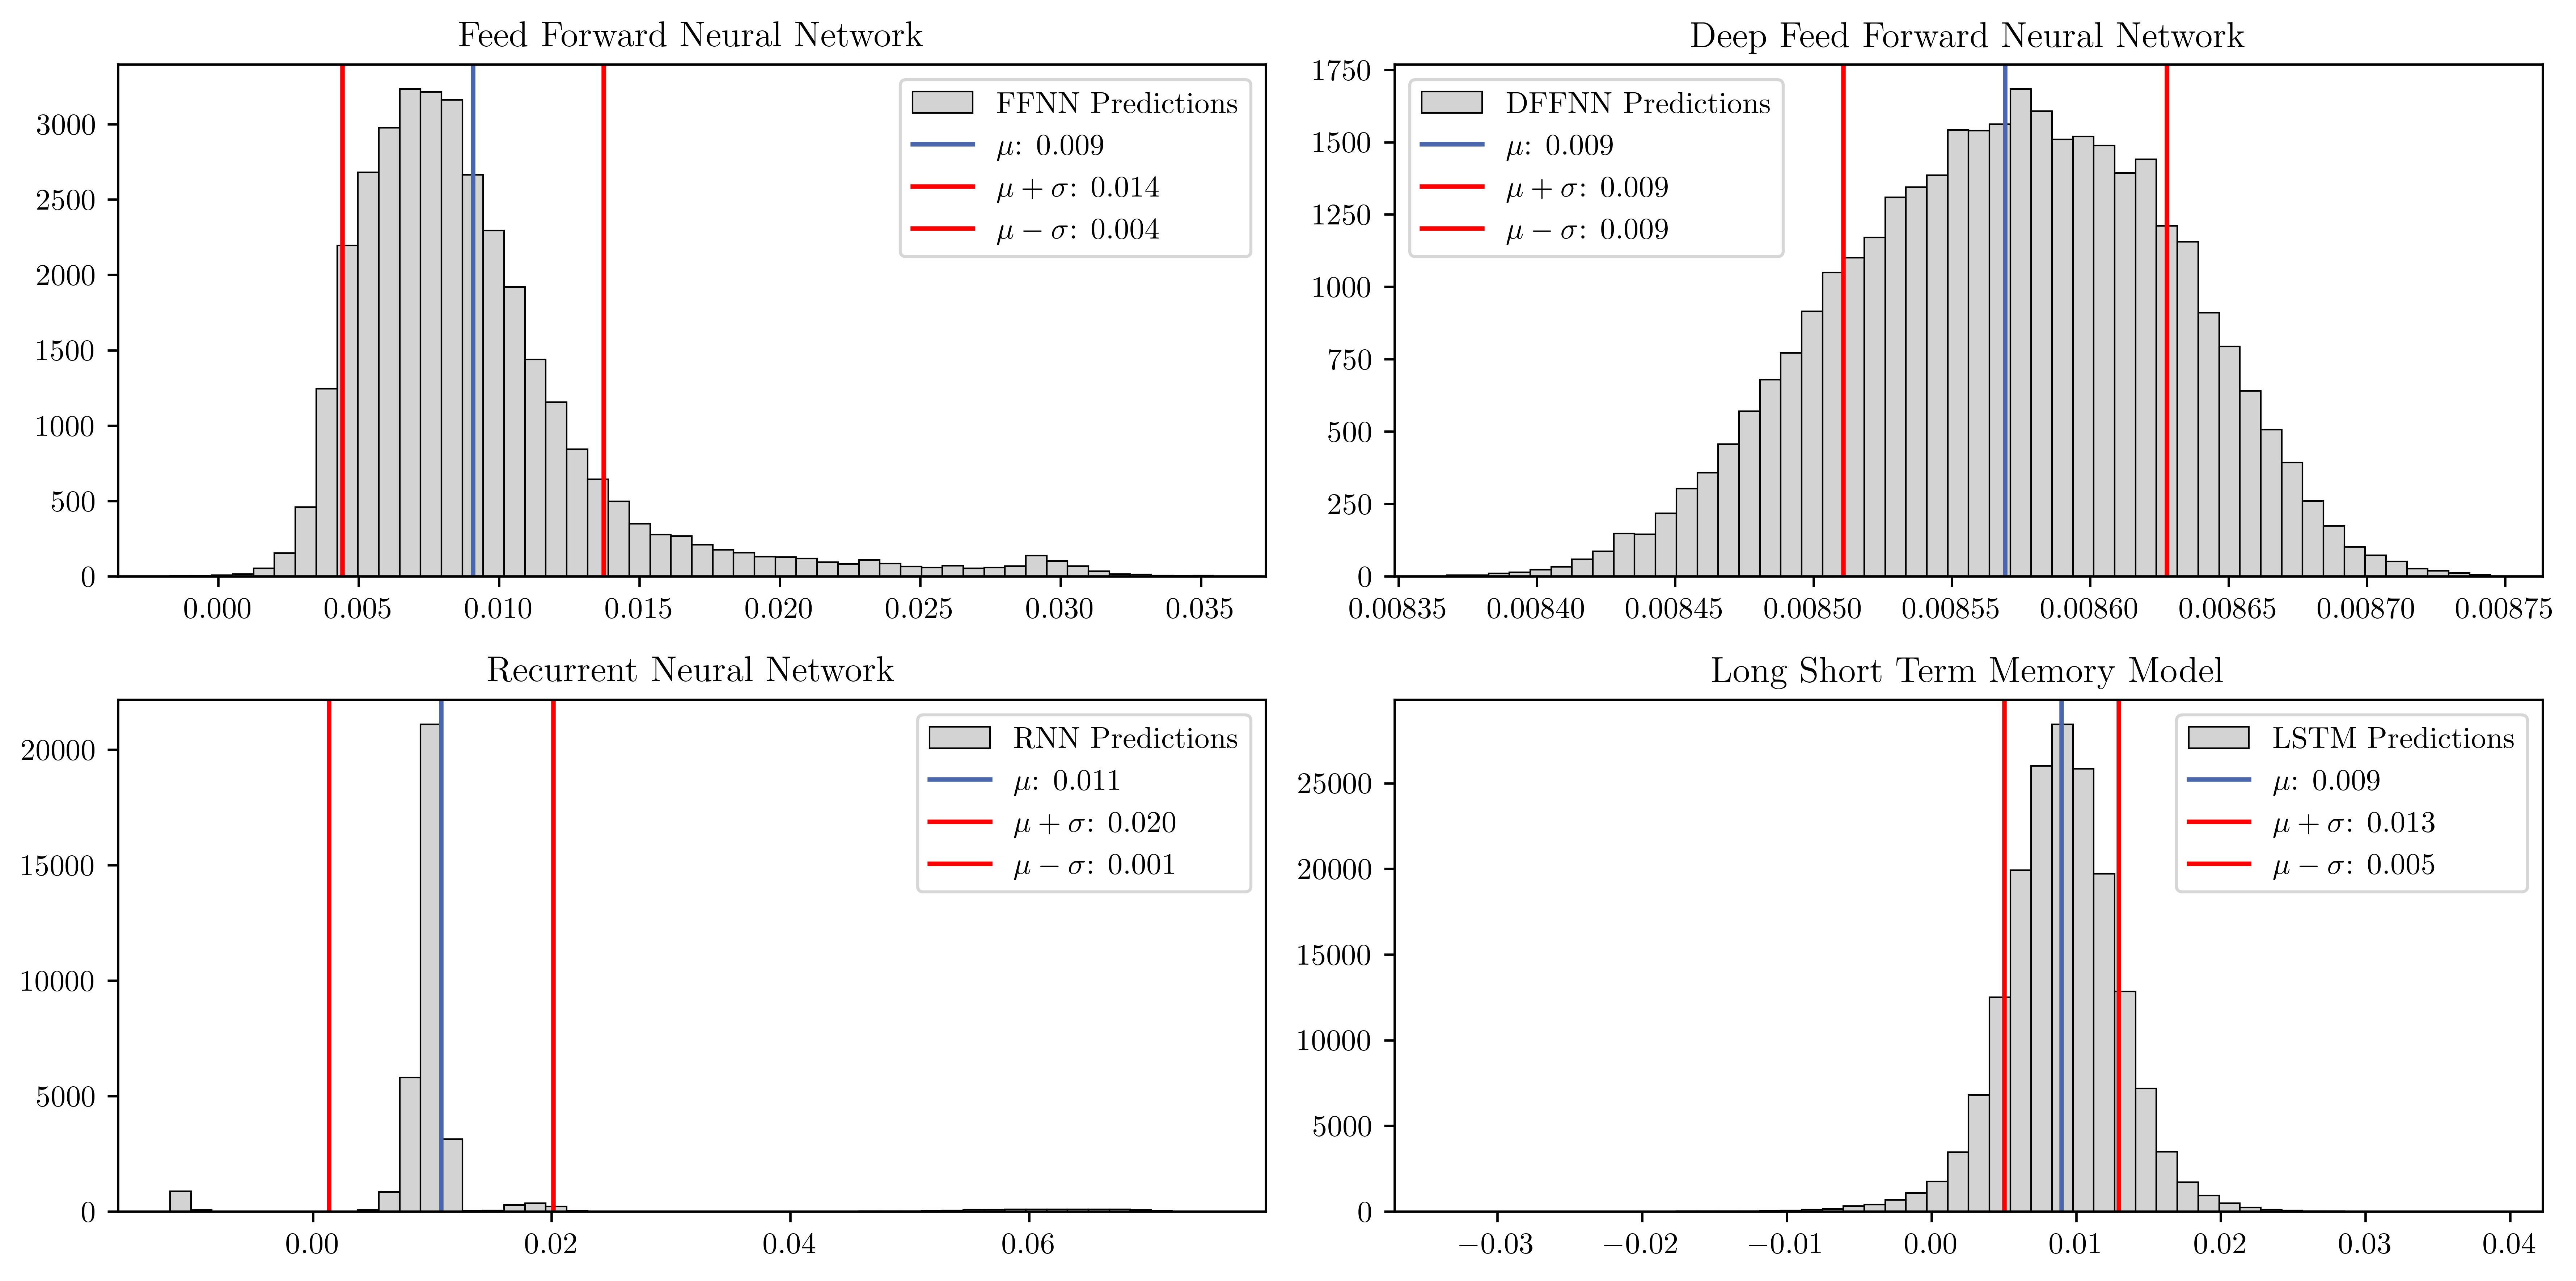

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2x2 grid for the subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 6), dpi=600)

# Define a helper function to add mean, median, and standard deviation lines
def add_stat_lines(ax, data, label):
    mean = np.mean(data)
    median = np.median(data)
    std = np.std(data)

    # Add lines for mean, median, and std
    ax.axvline(mean,       color=cbscolor,  linewidth=1.5,   label=r'$\mu$: {:.3f}'.format(mean))
    ax.axvline(mean + std, color='red',     linewidth=1.5,   label=r'$\mu + \sigma$: {:.3f}'.format(mean + std))
    ax.axvline(mean - std, color='red',     linewidth=1.5,   label=r'$\mu - \sigma$: {:.3f}'.format(mean - std))


    # Labeling the plot
    ax.set_title(label)
    ax.legend()

# FFNN Histogram
axs[0, 0].hist(ffnn_pred, bins=50, label="FFNN Predictions", color="lightgray", edgecolor="black", linewidth=0.5)
add_stat_lines(axs[0, 0], ffnn_pred, 'Feed Forward Neural Network')

# DFFNN Histogram
axs[0, 1].hist(dffnn_pred, bins=50, label="DFFNN Predictions", color="lightgray", edgecolor="black", linewidth=0.5)
add_stat_lines(axs[0, 1], dffnn_pred, 'Deep Feed Forward Neural Network')

# RNN Histogram
axs[1, 0].hist(rnn_pred, bins=50, label="RNN Predictions", color="lightgray", edgecolor="black", linewidth=0.5)
add_stat_lines(axs[1, 0], rnn_pred, 'Recurrent Neural Network')

# LSTM Histogram
axs[1, 1].hist(lstm_pred, bins=50, label="LSTM Predictions", color="lightgray", edgecolor="black", linewidth=0.5)
add_stat_lines(axs[1, 1], lstm_pred, 'Long Short Term Memory Model')

# Adjust layout for better spacing
plt.tight_layout()

# Save and show plot
plt.savefig("pred_distributions_non_log.pdf", bbox_inches='tight')
plt.show()

## **2.3 Label distributions**

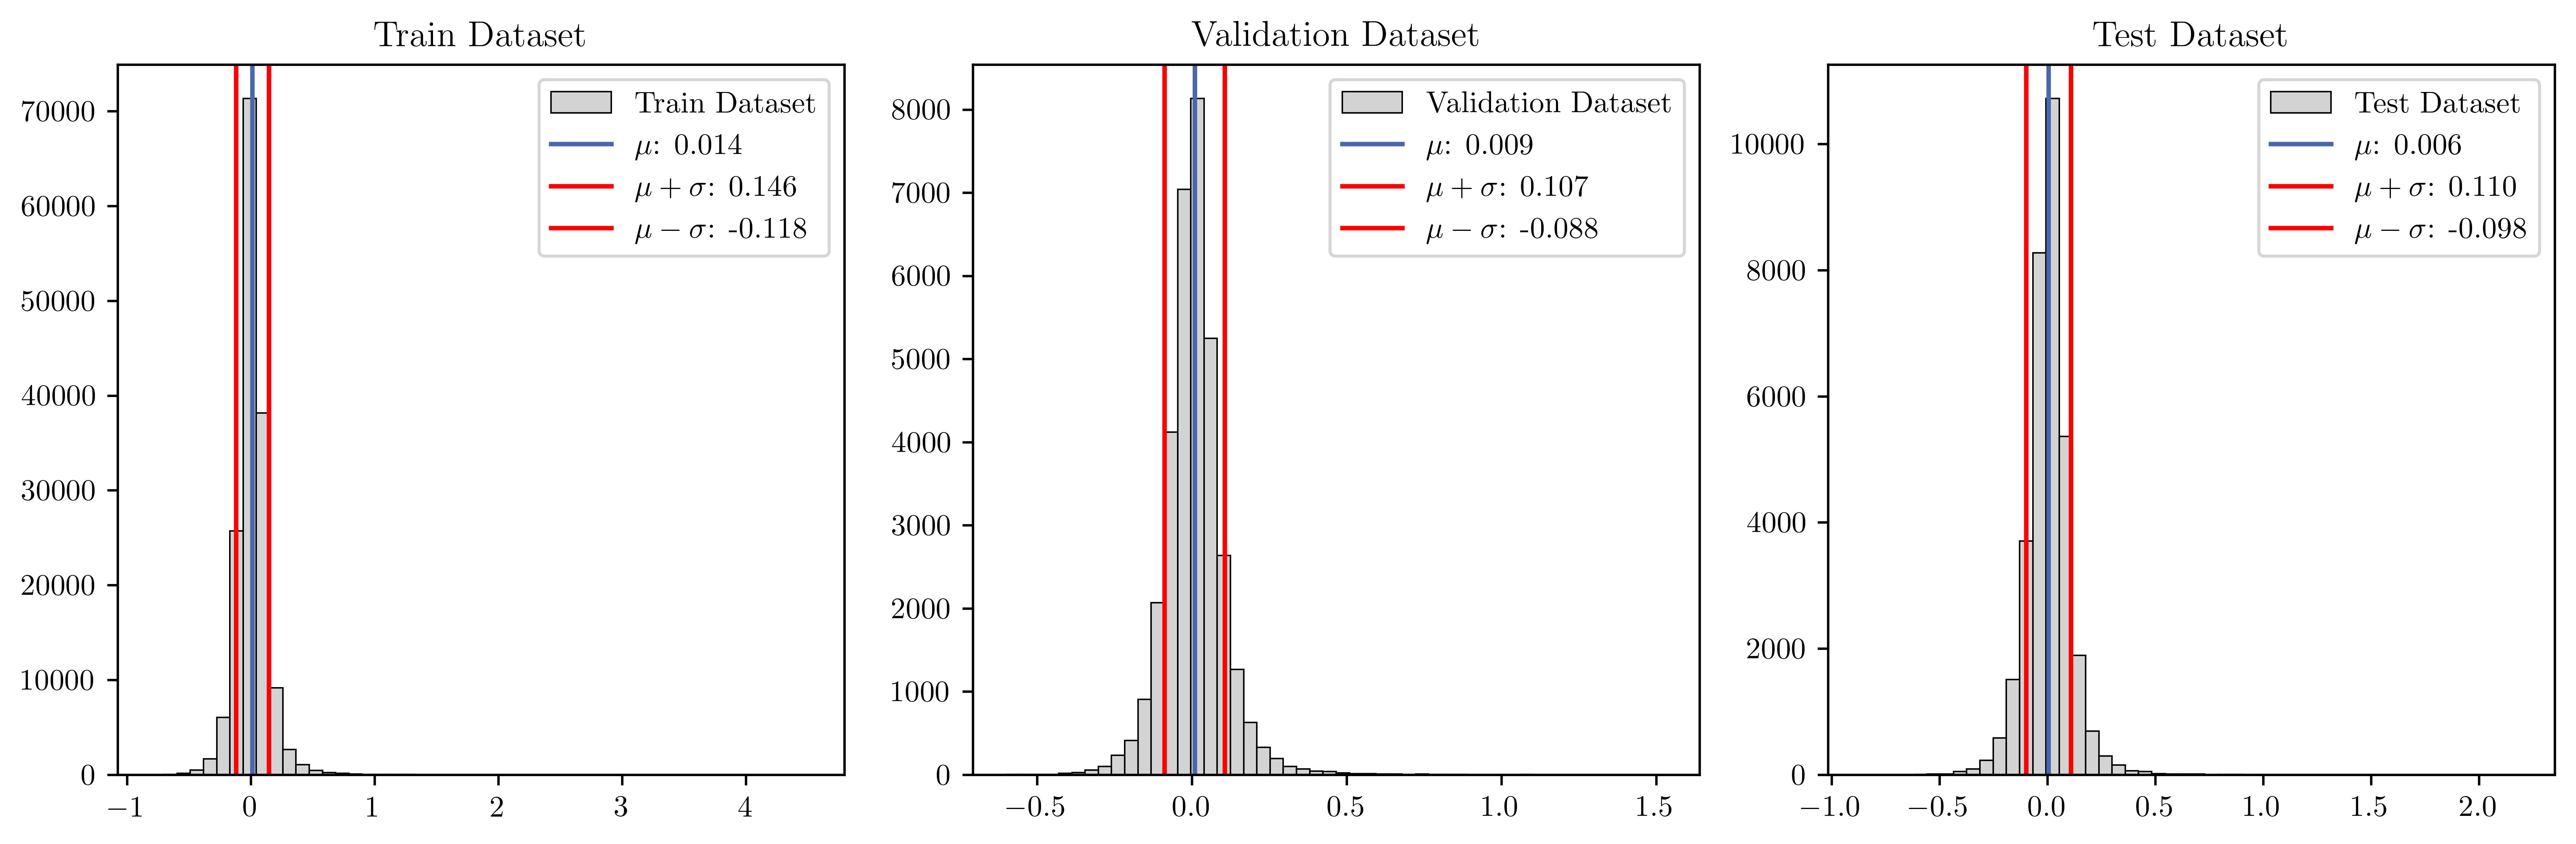

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2x2 grid for the subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=600)

# Define a helper function to add mean, median, and standard deviation lines
def add_stat_lines(ax, data, label):
    mean = np.mean(data)
    median = np.median(data)
    std = np.std(data)

    # Add lines for mean, median, and std
    ax.axvline(mean,       color=cbscolor,  linewidth=1.5,   label=r'$\mu$: {:.3f}'.format(mean))
    ax.axvline(mean + std, color='red',     linewidth=1.5,   label=r'$\mu + \sigma$: {:.3f}'.format(mean + std))
    ax.axvline(mean - std, color='red',     linewidth=1.5,   label=r'$\mu - \sigma$: {:.3f}'.format(mean - std))

    # Labeling the plot
    ax.set_title(label)
    ax.legend()

# FFNN Histogram
axs[0].hist(ff_y_train, bins=50, label="Train Dataset", color="lightgray", edgecolor="black", linewidth=0.5)
add_stat_lines(axs[0], ff_y_train, 'Train Dataset')

axs[1].hist(ff_y_val, bins=50, label="Validation Dataset", color="lightgray", edgecolor="black", linewidth=0.5)
add_stat_lines(axs[1], ff_y_val, 'Validation Dataset')

axs[2].hist(ff_y_test, bins=50, label="Test Dataset", color="lightgray", edgecolor="black", linewidth=0.5)
add_stat_lines(axs[2], ff_y_test, 'Test Dataset')

# Adjust layout for better spacing
plt.tight_layout()

# Save and show plot
plt.savefig("label_distributions.pdf", bbox_inches='tight')
plt.show()

In [ ]:
print(f"{'Test sample true mean:':40s} {ff_y_test.mean()}")
print(f"{'Test sample true variance:':40s} {ff_y_test.var()}")
print("")
print(f"{'Val sample true mean:':40s} {ff_y_val.mean()}")
print(f"{'Val sample true variance:':40s} {ff_y_val.var()}")
print("")
print(f"{'Train sample true mean:':40s} {ff_y_train.mean()}")
print(f"{'Train sample true variance:':40s} {ff_y_train.var()}")

Test sample true mean:                   0.006080972567972118
Test sample true variance:               0.010745897411350548

Val sample true mean:                    0.009276649744746663
Val sample true variance:                0.009515638272101744

Train sample true mean:                  0.013810806787030555
Train sample true variance:              0.01743739161798365


# **3 Sign accuary**

In [ ]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, classification_report
)


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Define a helper function with negative-class metrics added
def print_metrics(true, pred, model_name):
    sign_true = np.sign(true)
    sign_pred = np.sign(pred)

    accuracy = accuracy_score(sign_true, sign_pred)
    precision = precision_score(sign_true, sign_pred, pos_label=1)
    recall = recall_score(sign_true, sign_pred, pos_label=1)
    f1 = f1_score(sign_true, sign_pred, pos_label=1)

    cm = confusion_matrix(sign_true, sign_pred, labels=[-1, 1])
    TN, FP = cm[0, 0], cm[0, 1]
    FN, TP = cm[1, 0], cm[1, 1]

    negative_precision = TN / (TN + FN) if (TN + FN) > 0 else 0
    negative_recall = TN / (TN + FP) if (TN + FP) > 0 else 0
    negative_f1 = (2 * negative_precision * negative_recall) / (negative_precision + negative_recall) if (negative_precision + negative_recall) > 0 else 0

    print(f"\n=== {model_name} Metrics ===")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Accuracy:               {accuracy:.2f}")
    print(f"Positive Precision:     {precision:.2f}")
    print(f"Positive Recall:        {recall:.2f}")
    print(f"Positive F1 Score:      {f1:.2f}")
    print(f"Negative Precision:     {negative_precision:.2f}")
    print(f"Negative Recall (Spec): {negative_recall:.2f}")
    print(f"Negative F1 Score:      {negative_f1:.2f}")

# Call the function for each model
print_metrics(ffnn_true, ffnn_pred, "FFNN")
print_metrics(dffnn_true, dffnn_pred, "DFFNN")
print_metrics(rnn_true, rnn_pred, "RNN")
print_metrics(lstm_true, lstm_pred, "LSTM")


=== FFNN Metrics ===
Confusion Matrix:
[[    4 15599]
 [    1 18164]]
Accuracy:               0.54
Positive Precision:     0.54
Positive Recall:        1.00
Positive F1 Score:      0.70
Negative Precision:     0.80
Negative Recall (Spec): 0.00
Negative F1 Score:      0.00

=== DFFNN Metrics ===
Confusion Matrix:
[[    0 15603]
 [    0 18165]]
Accuracy:               0.54
Positive Precision:     0.54
Positive Recall:        1.00
Positive F1 Score:      0.70
Negative Precision:     0.00
Negative Recall (Spec): 0.00
Negative F1 Score:      0.00

=== RNN Metrics ===
Confusion Matrix:
[[  448 15155]
 [  490 17675]]
Accuracy:               0.54
Positive Precision:     0.54
Positive Recall:        0.97
Positive F1 Score:      0.69
Negative Precision:     0.48
Negative Recall (Spec): 0.03
Negative F1 Score:      0.05

=== LSTM Metrics ===
Confusion Matrix:
[[ 1430 79669]
 [ 1775 91594]]
Accuracy:               0.53
Positive Precision:     0.53
Positive Recall:        0.98
Positive F1 Score:  

# **4 Simplictic Models**

## **4.1 Linear Model**

In order to evaluate the performance gains from using a neural network to predict stock returns we seek to create a simple linear model that predicts stock returns.

In [ ]:
# Import nessecary packages
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create linear model
lr_model = LinearRegression()
lr_model.fit(ff_X_train, ff_y_train)

# Create predictions on test data
lr_model_y_pred_test = lr_model.predict(ff_X_test)

We now evaluate the losses of the linear model and calculate a few metrics, so we easier can compare with neural networks.

In [ ]:
# Test data statistics
lr_model_mse_test = mean_squared_error(ff_y_test.values, lr_model_y_pred_test)
print(f"{'Test MSE for Linear Regression:':40s} {lr_model_mse_test}")

# Train data statistics
lr_model_y_pred_train = lr_model.predict(ff_X_train)
lr_model_mse_train = mean_squared_error(ff_y_train.values, lr_model_y_pred_train)
print(f"{'Train MSE for Linear Regression:':40s} {lr_model_mse_train}")

Test MSE for Linear Regression:          0.0110236488470665
Train MSE for Linear Regression:         0.017265843731509547


In [ ]:
# Directional accurcay (hit ratio)
directional_acc_test = np.mean(np.multiply(lr_model_y_pred_test, ff_y_test.values) > 0)
print(f"{'Directional accuracy test data:':40s} {directional_acc_test:.7f}")

Directional accuracy test data:          0.5159322


## **4.2 Mean predictor**

We also make the simplist model possible: predicting the mean of the training data.

In [ ]:
# Packages
import numpy as np
from sklearn.metrics import mean_squared_error

# Calculate mean of training target
mean_train = np.mean(ff_y_train)

# Predict the mean for all training and test samples
mean_y_pred_train = np.full_like(ff_y_train, fill_value=mean_train)
mean_y_pred_test = np.full_like(ff_y_test, fill_value=mean_train)

We again create simple performance metrics to enable comparrsion of the models.

In [ ]:
# Calculate MSE for train and test
mse_train_mean = mean_squared_error(ff_y_train, mean_y_pred_train)
mse_test_mean = mean_squared_error(ff_y_test, mean_y_pred_test)

print(f"{'Train MSE for Mean Predictor:':40s} {mse_train_mean}")
print(f"{'Test MSE for Mean Predictor:':40s} {mse_test_mean}")

Train MSE for Mean Predictor:            0.01743728096340173
Test MSE for Mean Predictor:             0.010805329521165542


We also calcualte the directional accuracy.

In [ ]:
# Calculate directional accuracy for mean predictor (usually low but just to check)
directional_acc_train_mean = np.mean(np.multiply(mean_y_pred_train, ff_y_train.values) > 0)
directional_acc_test_mean = np.mean(np.multiply(mean_y_pred_test, ff_y_test.values) > 0)

print(f"{'Directional accuracy train data (mean predictor):':50s} {directional_acc_train_mean:.7f}")
print(f"{'Directional accuracy test data (mean predictor):':50s} {directional_acc_test_mean:.7f}")

Directional accuracy train data (mean predictor):  0.5440781
Directional accuracy test data (mean predictor):   0.5379353


# **5 Model Confidence Set**

In [ ]:
import numpy as np

# Assuming ff_y_test is a pandas Series or numpy array

# 1. Linear regression predictions on test set (you already have this)
# y_pred_test = lr_model.predict(ff_X_test)

# Calculate per-sample squared errors for linear regression
lr_mcs_losses = np.square(y_pred_test.flatten() - ff_y_test.values.flatten())

# 2. Mean predictor predictions on test set
mean_pred_test = np.full_like(ff_y_test.values.flatten(), fill_value=np.mean(ff_y_train.values.flatten()))

# Calculate per-sample squared errors for mean predictor
mean_mcs_losses = np.square(mean_pred_test - ff_y_test.values.flatten())


## **5.1 Feed Forward Neural Network Losses**

For feed forward network types we make one prediction per observation. So no need to calcualte special losses. This goes for both feed forward and deep feed forward.

The first return is stock 1, eom 1, the second is stock 1 eom 2, etc.

In [ ]:
# Predict on test data
ffnn_predict_test = ffnn.predict(ff_X_test, verbose=0)

# Calculate losses for Model Confidence Set (mcs)
ffnn_mcs_losses = np.square(ffnn_predict_test.flatten() - ff_y_test.values.flatten())

## **5.2 Deep Feed Forward Neural Network Losses**

Same as with feed forward.

In [ ]:
# Predict on test data
dffnn_predict_test = dffnn.predict(ff_X_test, verbose=0)

# Calculate losses for Model Confidence Set (mcs)
dffnn_mcs_losses = np.square(dffnn_predict_test.flatten() - ff_y_test.values.flatten())

## **5.3 Recurrent Neural Network Losses**

Since the sequence length is exactly the amount of observations we do not need to worry about making several predictions per stock.

In [ ]:
# Predict on test data
rnn_predict_test = rnn.predict(rnn_X_test, verbose=0)

# Calcualte losses used for Model Confidence Set (mcs)
rnn_mcs_losses = np.square(rnn_y_test.flatten() - rnn_predict_test.flatten())

## **5.4 Long Short Term Memory Losses**

Here we need to think carefully about how the loss for each day is calculated.

In [ ]:
lstm_predict_test = lstm.predict(lstm_X_test, verbose=0)

First we group the predictions by date and security.

In [ ]:
n_stocks = 938
n_dates = 36
window_len = 6
samples_per_stock = n_dates - window_len + 1  # 31
total_samples = n_stocks * samples_per_stock  # 29078

# Flatten predictions and errors
pred_vals = lstm_predict_test.squeeze(-1)       # shape (29078, 6)
label_vals = lstm_y_test.squeeze(-1)            # shape (29078, 6)
squared_errors = (pred_vals - label_vals) ** 2  # shape (29078, 6)

# Identify stock and date for each prediction to
stock_ids = np.repeat(np.arange(n_stocks), samples_per_stock)    # shape (29078,)
window_starts = np.tile(np.arange(samples_per_stock), n_stocks)  # shape (29078,)
date_indices = window_starts[:, None] + np.arange(window_len)    # shape (29078, 6)

# Flatten to per-prediction entries
flat_stock_ids = np.repeat(stock_ids, window_len)  # shape (29078 * 6,)
flat_date_indices = date_indices.flatten()         # shape (29078 * 6,)
flat_squared_errors = squared_errors.flatten()     # shape (29078 * 6,)

# Accumulate sum of squared errors and counts
sum_errors = np.zeros((n_stocks, n_dates))
count_errors = np.zeros((n_stocks, n_dates))
np.add.at(sum_errors, (flat_stock_ids, flat_date_indices), flat_squared_errors)
np.add.at(count_errors, (flat_stock_ids, flat_date_indices), 1)

# Compute mean squared error per stock/date
with np.errstate(divide='ignore', invalid='ignore'):
    avg_mse = np.divide(sum_errors, count_errors, where=count_errors != 0)

# Final array of errors
lstm_mcs_losses = avg_mse.flatten()

## **5.5 Linear and Mean Model**

In [ ]:
lr_mcs_losses = np.square(lr_model_y_pred_test - ff_y_test.values)
mean_mcs_losses = np.square(mean_y_pred_test - ff_y_test.values)

## **5.6 Model comparison**

In [ ]:
mcs_losses = pd.DataFrame(np.c_[ffnn_mcs_losses, dffnn_mcs_losses, rnn_mcs_losses, lstm_mcs_losses, lr_mcs_losses, mean_mcs_losses], columns=['ffnn', 'dffnn', 'rnn', 'lstm', 'linearmodel', 'mean'])
mcs = ModelConfidenceSet(mcs_losses, n_boot=10_000, alpha=0.05, show_progress=True)
mcs.compute()
print(mcs.results())

Computing MCS: 100%|██████████| 5/5 [00:00<00:00, 620.70model/s]

             pvalues    status
models                        
linearmodel   0.0000  excluded
rnn           0.0000  excluded
mean          0.0000  excluded
lstm          0.0000  excluded
ffnn          0.0004  excluded
dffnn         1.0000  included


In [ ]:
mcs_losses = mcs_losses.drop(columns=['dffnn'])
mcs = ModelConfidenceSet(mcs_losses, n_boot=10_000, alpha=0.05, show_progress=True)
mcs.compute()
print(mcs.results())

Computing MCS: 100%|██████████| 4/4 [00:00<00:00, 483.09model/s]

             pvalues    status
models                        
linearmodel   0.0000  excluded
rnn           0.0020  excluded
mean          0.0020  excluded
ffnn          0.8146  included
lstm          1.0000  included


In [ ]:
mcs_losses = mcs_losses.drop(columns=['ffnn', 'lstm'])
mcs = ModelConfidenceSet(mcs_losses, n_boot=10_000, alpha=0.05, show_progress=True)
mcs.compute()
print(mcs.results())

ValueError: losses must have more than one column (models)

# **6 Precision@K**

Referred to as P@K (`p_at_k` in code).

In [30]:
def top_bottom_hit_rate(pred, true, top_pct=0.2):
    assert pred.shape == true.shape
    n = len(true)
    k = int(top_pct * n)

    # Get top/bottom K indices
    true_top = set(np.argsort(true)[-k:])
    true_bottom = set(np.argsort(true)[:k])
    pred_top = set(np.argsort(pred)[-k:])
    pred_bottom = set(np.argsort(pred)[:k])

    # Calculate hit rate (overlap / actual top K)
    top_hit_rate = len(true_top & pred_top) / k
    bottom_hit_rate = len(true_bottom & pred_bottom) / k

    return top_hit_rate, bottom_hit_rate

In [52]:
# Flattened arrays already
ffnn_pred = ffnn_pred.flatten()
ffnn_true = ffnn_true.flatten()

dffnn_pred = dffnn_pred.flatten()
dffnn_true = dffnn_true.flatten()

rnn_pred = rnn_pred.flatten()
rnn_true = rnn_true.flatten()

lstm_pred = lstm_pred.flatten()
lstm_true = lstm_true.flatten()

models = {
    'FFNN': (ffnn_pred, ffnn_true),
    'DFFNN': (dffnn_pred, dffnn_true),
    'RNN': (rnn_pred, rnn_true),
    'LSTM': (lstm_pred, lstm_true),
}


for name, (pred, true) in models.items():
    top_hit, bottom_hit = top_bottom_hit_rate(pred, true, 0.25)
    top_str = f"{top_hit:.2%}"
    print(f"{name:10s} Top 20% Hit Rate: {top_str}{' ' * (20 - len(top_str))}Bottom 20% Hit Rate: {bottom_hit:.2%}")


FFNN       Top 20% Hit Rate: 30.10%              Bottom 20% Hit Rate: 18.86%
DFFNN      Top 20% Hit Rate: 27.92%              Bottom 20% Hit Rate: 17.86%
RNN        Top 20% Hit Rate: 21.97%              Bottom 20% Hit Rate: 27.45%
LSTM       Top 20% Hit Rate: 27.06%              Bottom 20% Hit Rate: 21.35%


In [46]:
def bootstrap_hit_rate(pred, true, top_pct=0.2, n_boot=1000, seed=42):
    np.random.seed(seed)
    n = len(true)
    k = int(top_pct * n)

    top_hits = []
    bottom_hits = []

    for _ in range(n_boot):
        idx = np.random.choice(n, size=n, replace=True)
        pred_sample = pred[idx]
        true_sample = true[idx]

        # Get top/bottom K indices
        true_top = set(np.argsort(true_sample)[-k:])
        true_bottom = set(np.argsort(true_sample)[:k])
        pred_top = set(np.argsort(pred_sample)[-k:])
        pred_bottom = set(np.argsort(pred_sample)[:k])

        # Calculate hit rate
        top_hits.append(len(true_top & pred_top) / k)
        bottom_hits.append(len(true_bottom & pred_bottom) / k)

    return {
        "top_mean": np.mean(top_hits),
        "top_std": np.std(top_hits),
        "top_ci": np.percentile(top_hits, [2.5, 97.5]),
        "bottom_mean": np.mean(bottom_hits),
        "bottom_std": np.std(bottom_hits),
        "bottom_ci": np.percentile(bottom_hits, [2.5, 97.5])
    }


In [47]:
results = bootstrap_hit_rate(ffnn_pred, ffnn_true)

print(f"FFNN Top 20% Hit Rate:    {results['top_mean']:.2%} ± {results['top_std']:.2%} (95% CI: {results['top_ci'][0]:.2%}-{results['top_ci'][1]:.2%})")
print(f"FFNN Bottom 20% Hit Rate: {results['bottom_mean']:.2%} ± {results['bottom_std']:.2%} (95% CI: {results['bottom_ci'][0]:.2%}-{results['bottom_ci'][1]:.2%})")

FFNN Top 20% Hit Rate:    26.61% ± 0.47% (95% CI: 25.68%–27.54%)
FFNN Bottom 20% Hit Rate: 13.56% ± 0.40% (95% CI: 12.79%–14.39%)


In [48]:
results = bootstrap_hit_rate(dffnn_pred, dffnn_true)

print(f"FFNN Top 20% Hit Rate:    {results['top_mean']:.2%} ± {results['top_std']:.2%} (95% CI: {results['top_ci'][0]:.2%}-{results['top_ci'][1]:.2%})")
print(f"FFNN Bottom 20% Hit Rate: {results['bottom_mean']:.2%} ± {results['bottom_std']:.2%} (95% CI: {results['bottom_ci'][0]:.2%}-{results['bottom_ci'][1]:.2%})")

FFNN Top 20% Hit Rate:    24.38% ± 0.46% (95% CI: 23.47%-25.29%)
FFNN Bottom 20% Hit Rate: 12.54% ± 0.40% (95% CI: 11.77%-13.31%)


In [49]:
results = bootstrap_hit_rate(rnn_pred, rnn_true)

print(f"FFNN Top 20% Hit Rate:    {results['top_mean']:.2%} ± {results['top_std']:.2%} (95% CI: {results['top_ci'][0]:.2%}-{results['top_ci'][1]:.2%})")
print(f"FFNN Bottom 20% Hit Rate: {results['bottom_mean']:.2%} ± {results['bottom_std']:.2%} (95% CI: {results['bottom_ci'][0]:.2%}-{results['bottom_ci'][1]:.2%})")

FFNN Top 20% Hit Rate:    16.51% ± 0.42% (95% CI: 15.70%-17.38%)
FFNN Bottom 20% Hit Rate: 22.01% ± 0.43% (95% CI: 21.18%-22.85%)


In [50]:
results = bootstrap_hit_rate(lstm_pred, lstm_true)

print(f"FFNN Top 20% Hit Rate:    {results['top_mean']:.2%} ± {results['top_std']:.2%} (95% CI: {results['top_ci'][0]:.2%}-{results['top_ci'][1]:.2%})")
print(f"FFNN Bottom 20% Hit Rate: {results['bottom_mean']:.2%} ± {results['bottom_std']:.2%} (95% CI: {results['bottom_ci'][0]:.2%}-{results['bottom_ci'][1]:.2%})")

FFNN Top 20% Hit Rate:    22.72% ± 0.19% (95% CI: 22.35%-23.08%)
FFNN Bottom 20% Hit Rate: 15.70% ± 0.17% (95% CI: 15.34%-16.01%)
